In [157]:
import numpy as np
import pandas as pd

In [158]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Bayes Classifier 1:
Covariance matrix for all the classes is the same and is $\sigma^2 I$ 

In [159]:
class BayesClassifier1:
    def __init__(self):
        pass

    def __find_rep_temp(self, df_train):
        class_variances = df_train.groupby('Class').var()
        avg_var = class_variances.mean(axis=0)

        self.M = df_train['Class'].nunique()

        self.cov_mat = np.zeros((len(avg_var), len(avg_var)))
        for i in range(len(avg_var)):
            self.cov_mat[i][i] = avg_var[i]
        
        self.means = df_train.groupby('Class').mean()

        self.priors = df_train['Class'].value_counts() / len(df_train)

    def fit(self, X_train, y_train):
        df_train = pd.concat([X_train, y_train], axis=1)
        df_train = df_train.reset_index(drop=True)
    
        # finds the sigma and the mus
        self.__find_rep_temp(df_train)

    def __discriminant(self, x, mu, prior):
        return -1/2 * (np.transpose(x - mu) @ np.linalg.inv(self.cov_mat) @ (x - mu)) + np.log(prior)

    def predict(self, X_test):
        y_pred = []

        for idx in range(len(X_test)):
            x = X_test.iloc[idx]
            gs = []

            for i in range(self.M):
                gs.append(self.__discriminant(x, np.array(self.means.iloc[i]), np.array(self.priors.iloc[i])))
        
            y_pred.append(np.argmax(gs) + 1)

        return y_pred

In [160]:
def plot_decision_boundaries(classifier, X_test, y_test):
    x_min, x_max = X_test.iloc[:, 0].min() - 1, X_test.iloc[:, 0].max() + 1
    y_min, y_max = X_test.iloc[:, 1].min() - 1, X_test.iloc[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    Z = np.array(classifier.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)

    for class_label in classifier.means.index:
        plt.scatter(
            X_test[y_test == class_label].iloc[:, 0],
            X_test[y_test == class_label].iloc[:, 1],
            label=f"Class {class_label}",
            edgecolors='k'
        )
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundaries and Test Data')
    plt.legend()
    plt.show()

In [161]:
def confusion_mat(y_pred, y_test):
    M = np.unique(y_test).size

    conf_mat = np.zeros((M, M))

    for i in range(len(y_test)):
        conf_mat[y_pred[i]-1][y_test[i]-1] += 1
    
    return conf_mat

def classification_accuracy(y_pred, y_test):
    M = np.unique(y_test).size

    tp_tn = 0

    for i in range(len(y_test)):
        if y_pred[i] == y_test[i]:
            tp_tn += 1
    
    return tp_tn / len(y_pred)

def precision(y_pred, y_test, target_class):
    tp = 0
    fp =0

    for i in range(len(y_test)):
        if y_pred[i] == target_class and y_test[i] == target_class:
            tp += 1
        elif y_pred[i] == target_class:
            fp += 1

    return tp / (tp + fp)

def recall(y_pred, y_test, target_class):
    tp = 0
    fn = 0

    for i in range(len(y_test)):
        if y_pred[i] == target_class and y_test[i] == target_class:
            tp += 1
        elif y_pred[i] != target_class and y_test[i] == target_class:
            fn += 1

    return tp / (tp + fn)

def f_score(y_pred, y_test, target_class):
    prec = precision(y_pred, y_test, target_class)
    rec = recall(y_pred, y_test, target_class)

    return 2 * prec * rec / (prec + rec)

# Bayes Classifier 2:
Full Covariance matrix for all the classes is the same and is $\Sigma$

In [162]:
class BayesClassifier2:
    def __init__(self):
        pass

    def __find_rep_temp(self, df_train):
        self.M = df_train['Class'].nunique()

        self.means = df_train.groupby('Class').mean()
        self.covariance = np.zeros((df_train.shape[1] - 1, df_train.shape[1] - 1))

        for class_label in range(1, self.M + 1):
            class_data = df_train[df_train['Class'] == class_label].iloc[:, :-1]
            class_covaraince = class_data.cov()

            self.covariance += class_covaraince.values
        
        self.covariance /= self.M

        self.priors = df_train['Class'].value_counts() / len(df_train)

    def fit(self, X_train, y_train):
        df_train = pd.concat([X_train, y_train], axis=1)
        df_train = df_train.reset_index(drop=True)

        self.__find_rep_temp(df_train)

    def __discriminant(self, x, mu, prior):
        return -1/2 * (np.transpose(x - mu) @ np.linalg.inv(self.covariance) @ (x - mu)) + np.log(prior)
    
    def predict(self, X_test):
        y_pred = []

        for idx in range(len(X_test)):
            x = X_test.iloc[idx]
            gs = []

            for i in range(self.M):
                gs.append(self.__discriminant(x, np.array(self.means.iloc[i]), np.array(self.priors.iloc[i])))
            
            y_pred.append(np.argmax(gs) + 1)

        return y_pred

# Bayes Classifier 3:
Covariance matrix is diagonal and different for each class

In [163]:
class BayesClassifier3:
    def __init__(self):
        pass

    def __find_rep_temp(self, df_train):
        self.M = df_train['Class'].nunique()

        self.means = df_train.groupby('Class').mean()
        self.covariances = np.zeros((self.M, df_train.shape[1] - 1, df_train.shape[1] - 1))

        for class_label in range(1, self.M + 1):
            class_data = df_train[df_train['Class'] == class_label].iloc[:, :-1]
            class_covariance = class_data.cov()

            class_covariance = class_covariance.values
            
            # set all non-diagonal elements to zero (covariance matrix is diagonal)
            class_covariance = np.diag(np.diag(class_covariance))

            self.covariances[class_label - 1] = class_covariance

        self.priors = df_train['Class'].value_counts() / len(df_train)

    def fit(self, X_train, y_train):
        df_train = pd.concat([X_train, y_train], axis=1)
        df_train.reset_index(drop=True)

        self.__find_rep_temp(df_train)

    def __discriminant(self, x, mu, covariance, prior):
        return -1/2 * (np.transpose(x - mu) @ np.linalg.inv(covariance) @ (x - mu)) - 1/2 * np.log(np.linalg.det(covariance)) + np.log(prior)
    
    def predict(self, X_test):
        y_pred = []

        for idx in range(len(X_test)):
            x = X_test.iloc[idx]
            gs = []

            for i in range(self.M):
                gs.append(self.__discriminant(x, np.array(self.means.iloc[i]), np.array(self.covariances[i]), np.array(self.priors.iloc[i])))
            y_pred.append(np.argmax(gs) + 1)
        return y_pred

# Bayes Classifier 4:
Full covariance matrix for each class is different

In [164]:
class BayesClassifier4:
    def __init__(self):
        pass

    def __find_rep_temp(self, df_train):
        self.M = df_train['Class'].nunique()

        self.means = df_train.groupby('Class').mean()
        self.covariances = np.zeros((self.M, df_train.shape[1] - 1, df_train.shape[1] - 1))

        for class_label in range(1, self.M + 1):
            class_data = df_train[df_train['Class'] == class_label].iloc[:, :-1]
            class_covariance = class_data.cov()

            self.covariances[class_label - 1] = class_covariance

        self.priors = df_train['Class'].value_counts() / len(df_train)

    def fit(self, X_train, y_train):
        df_train = pd.concat([X_train, y_train], axis=1)
        df_train.reset_index(drop=True)

        self.__find_rep_temp(df_train)
    
    def __discriminant(self, x, mu, covariance, prior):
        return -1/2 * (np.transpose(x - mu) @ np.linalg.inv(covariance) @ (x - mu)) - 1/2 * np.log(np.linalg.det(covariance)) + np.log(prior)
    
    def predict(self, X_test):
        y_pred = []

        for idx in range(len(X_test)):
            x = X_test.iloc[idx]
            gs = []

            for i in range(self.M):
                gs.append(self.__discriminant(x, np.array(self.means.iloc[i]), np.array(self.covariances[i]), np.array(self.priors.iloc[i])))
            
            y_pred.append(np.argmax(gs) + 1)

        return y_pred

# Dataset 1: Linearly Separable dataset

In [165]:
ls_1 = pd.read_csv("Group15/LS_Group15/Class1.txt", sep=' ', header=None)
ls_2 = pd.read_csv("Group15/LS_Group15/Class2.txt", sep=' ', header=None)
ls_3 = pd.read_csv("Group15/LS_Group15/Class3.txt", sep=' ', header=None)

In [166]:
ls_1 = ls_1.assign(Class=1)
ls_2 = ls_2.assign(Class=2)
ls_3 = ls_3.assign(Class=3)

In [167]:
df_ls = pd.concat([ls_1, ls_2, ls_3], ignore_index=True)
df_ls

,0,1,Class
0,-2.2365,2.3224,1
1,2.4445,4.5807,1
2,1.8720,1.1315,1
3,5.1338,1.0316,1
4,2.1731,2.2868,1
...,...,...,...
1495,17.1120,-6.9613,3
1496,16.8170,-2.7400,3
1497,14.7910,-3.5821,3
1498,17.1720,-9.3333,3


In [168]:
from sklearn.model_selection import train_test_split

X_ls, y_ls = df_ls.drop('Class', axis=1), df_ls['Class']
X_train_ls, X_test_ls, y_train_ls, y_test_ls = train_test_split(X_ls, y_ls, test_size=0.3, shuffle=True)

In [169]:
bc1 = BayesClassifier1()
bc2 = BayesClassifier2()
bc3 = BayesClassifier3()
bc4 = BayesClassifier4()

classifiers = [bc1, bc2, bc3, bc4]

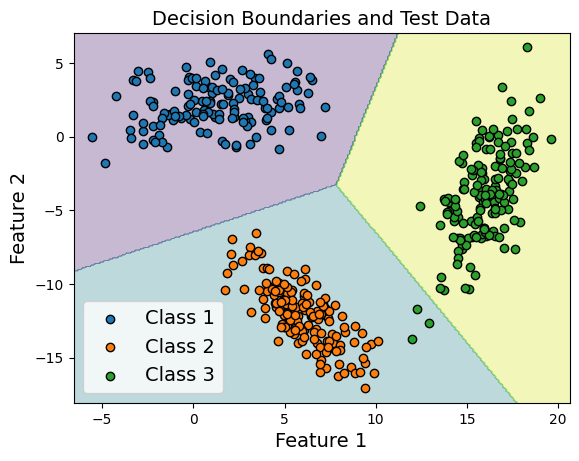

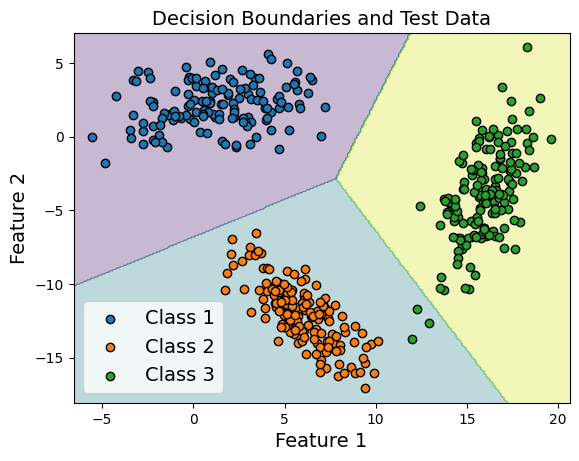

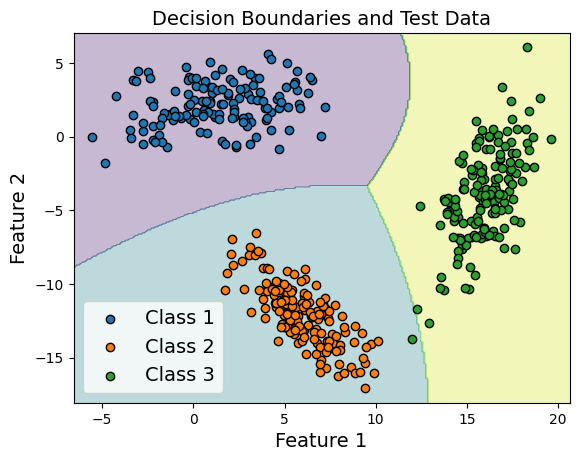

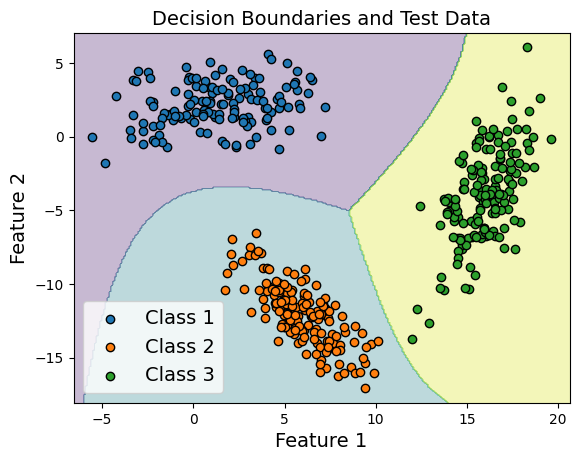

In [170]:
conf_mat_ls = []

for classifier in classifiers:
    classifier.fit(X_train_ls, y_train_ls)
    
    y_pred_ls = classifier.predict(X_test_ls)

    # conf_mat_ls.append(confusion_mat(y_pred_ls, y_test_ls))
    plot_decision_boundaries(classifier, X_test_ls, y_test_ls)

# Dataset 2: Non-linearly separable dataset

In [171]:
df_nls = pd.read_csv("Group15/NLS_Group15.txt", skiprows=1, delim_whitespace=True, names=['Column1', 'Column2'])

In [172]:
df_nls.head()

,Column1,Column2
0,1.006419,7.971535
1,-8.568597,-0.994905
2,-7.830411,-6.082278
3,-3.094843,0.282297
4,-6.523232,5.807146


In [173]:
df_nls.loc[:2445, 'Class'] = 1
df_nls.loc[2446:, 'Class'] = 2
df_nls

,Column1,Column2,Class
0,1.006419,7.971535,1.0
1,-8.568597,-0.994905,1.0
2,-7.830411,-6.082278,1.0
3,-3.094843,0.282297,1.0
4,-6.523232,5.807146,1.0
...,...,...,...
4888,3.142440,2.856512,2.0
4889,9.864461,-0.200095,2.0
4890,7.845237,8.196611,2.0
4891,-2.968971,-6.084928,2.0


In [174]:
from sklearn.model_selection import train_test_split

X_nls, y_nls = df_nls.drop('Class', axis=1), df_nls['Class']
X_train_nls, X_test_nls, y_train_nls, y_test_nls = train_test_split(X_nls, y_nls, test_size=0.3, shuffle=True)

In [175]:
bc1 = BayesClassifier1()
bc2 = BayesClassifier2()
bc3 = BayesClassifier3()
bc4 = BayesClassifier4()

classifiers = [bc1, bc2, bc3, bc4]

C:\Users\HP\AppData\Local\Temp\ipykernel_4360\990597564.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.cov_mat[i][i] = avg_var[i]


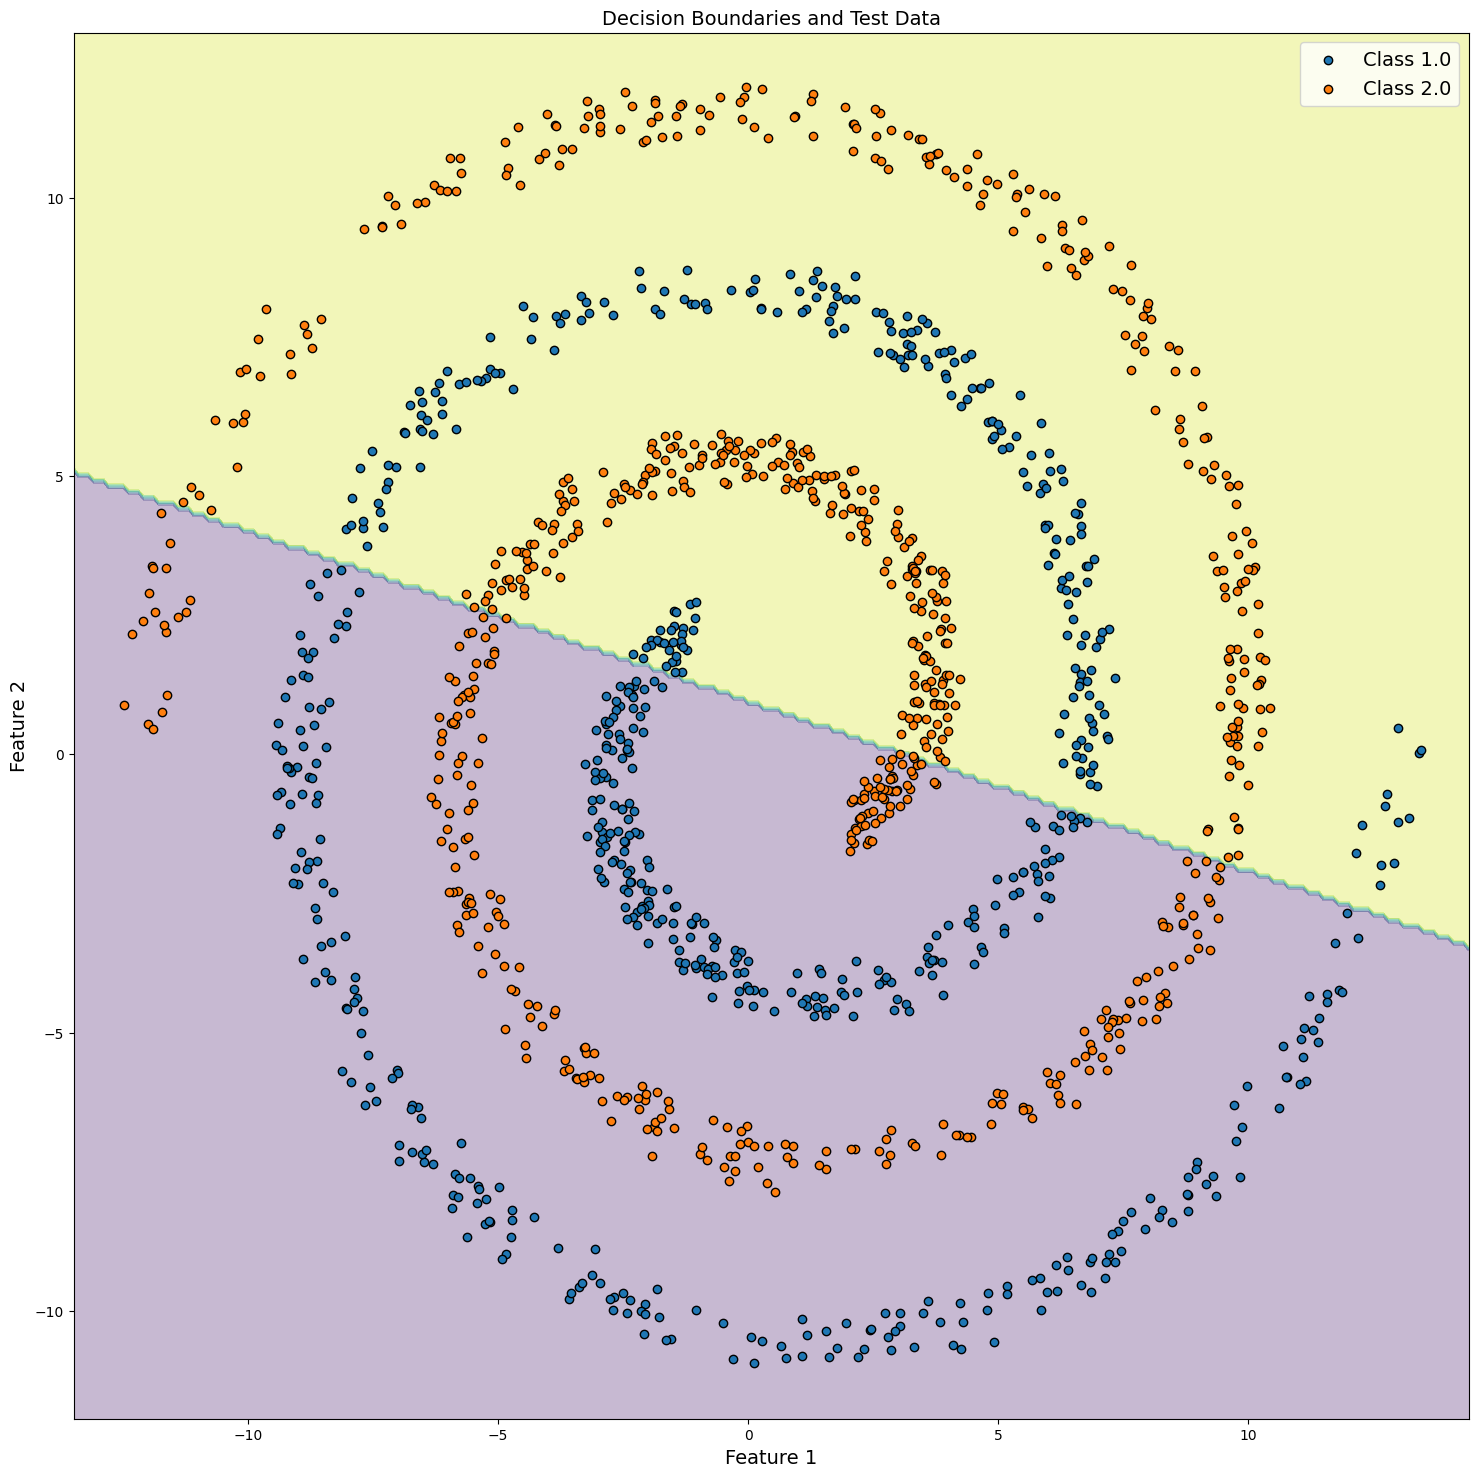

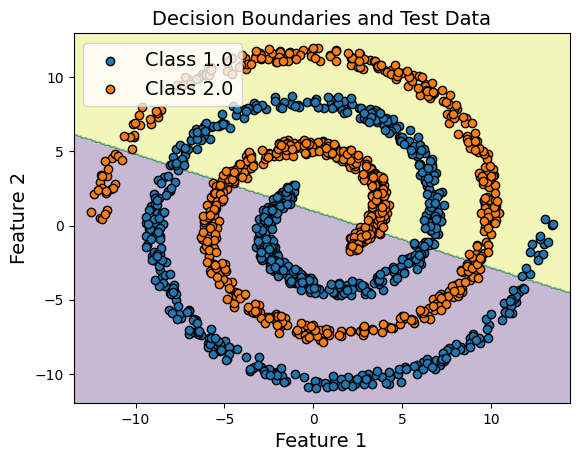

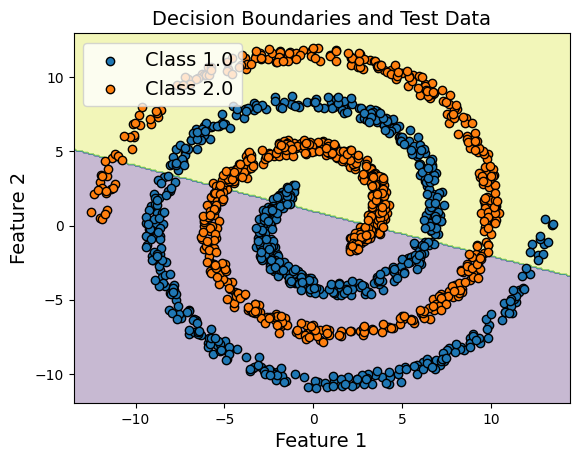

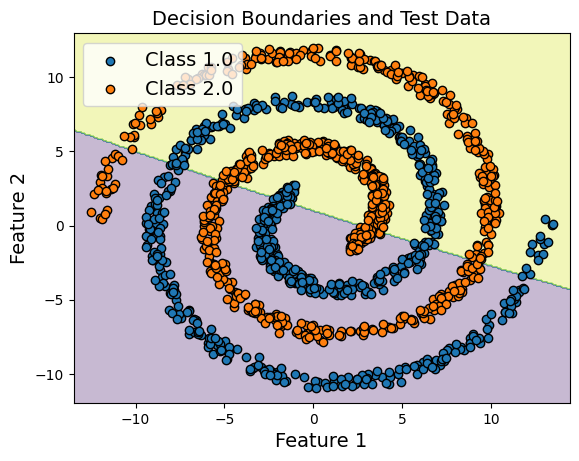

In [176]:
conf_mat_ls = []

plt.figure(figsize=(18, 18))

for classifier in classifiers:
    classifier.fit(X_train_nls, y_train_nls)
    
    # y_pred_nls = classifier.predict(X_test_nls)
    
    # conf_mat_ls.append(confusion_mat(y_pred_ls, y_test_ls))
    plot_decision_boundaries(classifier, X_test_nls, y_test_nls)

# Dataset 3: Real-world data

In [183]:
rd_1 = pd.read_csv("Group15/rd_group15/Class1.txt", delim_whitespace=True, header=None)
rd_2 = pd.read_csv("Group15/rd_group15/class2.txt", delim_whitespace=True, header=None)
rd_3 = pd.read_csv("Group15/rd_group15/class3.txt", delim_whitespace=True, header=None)

In [184]:
rd_1 = rd_1.assign(Class=1)
rd_2 = rd_2.assign(Class=2)
rd_3 = rd_3.assign(Class=3)

In [185]:
df_rd = pd.concat([rd_1, rd_2, rd_3], ignore_index=True)
df_rd

,0,1,Class
0,785.15625,1152.34375,1
1,757.81250,1136.71875,1
2,789.06250,1085.93750,1
3,781.25000,1101.56250,1
4,789.06250,1105.46875,1
...,...,...,...
7101,324.21875,875.00000,3
7102,312.50000,730.46875,3
7103,296.87500,1000.00000,3
7104,343.75000,765.62500,3


In [186]:
X_rd, y_rd = df_rd.drop('Class', axis=1), df_rd['Class']
X_train_rd, X_test_rd, y_train_rd, y_test_rd = train_test_split(X_rd, y_rd, test_size=0.3, shuffle=True)

In [187]:
bc1 = BayesClassifier1()
bc2 = BayesClassifier2()
bc3 = BayesClassifier3()
bc4 = BayesClassifier4()

classifiers = [bc1, bc2, bc3, bc4]

In [190]:
def plot_decision_boundaries(classifier, X_test, y_test):
    x_min, x_max = X_test.iloc[:, 0].min() - 1, X_test.iloc[:, 0].max() + 1
    y_min, y_max = X_test.iloc[:, 1].min() - 1, X_test.iloc[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1))

    Z = np.array(classifier.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)

    for class_label in classifier.means.index:
        plt.scatter(
            X_test[y_test == class_label].iloc[:, 0],
            X_test[y_test == class_label].iloc[:, 1],
            label=f"Class {class_label}",
            edgecolors='k'
        )
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundaries and Test Data')
    plt.legend()
    plt.show()

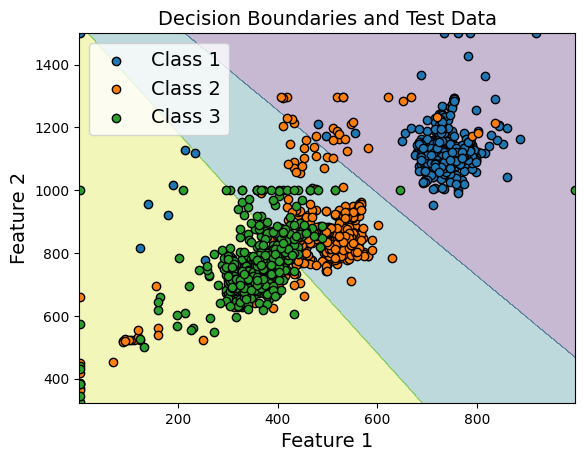

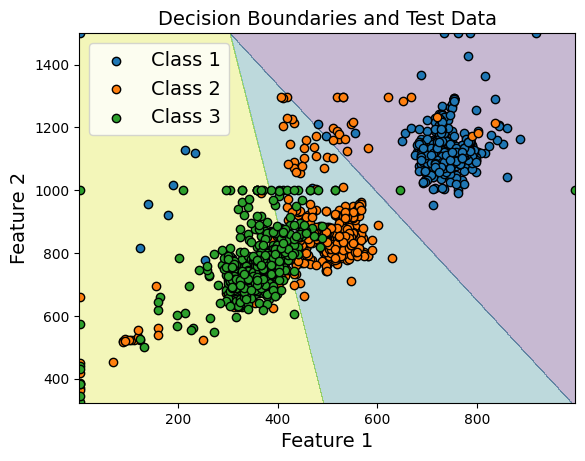

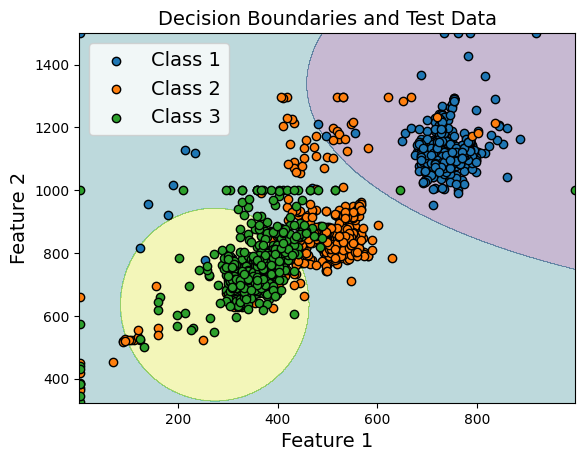

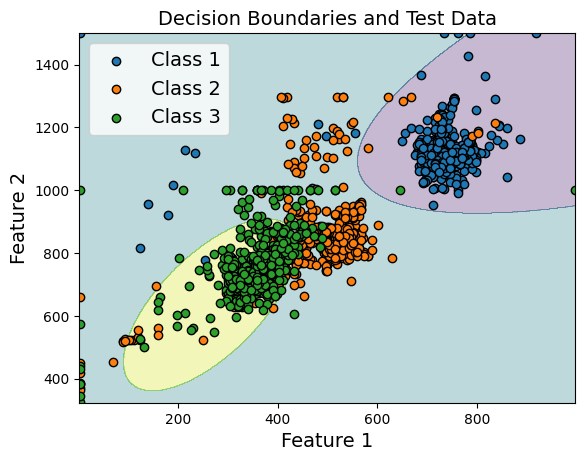

In [191]:
conf_mat_rd = []

for classifier in classifiers:
    classifier.fit(X_train_rd, y_train_rd)
    
    # y_pred_rd = classifier.predict(X_test_rd)

    # conf_mat_rd.append(confusion_mat(y_pred_rd, y_test_rd))
    plot_decision_boundaries(classifier, X_test_rd, y_test_rd)